In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [2]:
# read in the data
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')

In [3]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

In [4]:
edges.head()

,from,to,l,h,time,timeU,timeUCB,border
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0


In [5]:
nodes.head()

,Agglomeration_ID,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
0,2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
1,5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
2,7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
3,4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4,4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


Text(0.5, 0.98, 'African Urban Network')

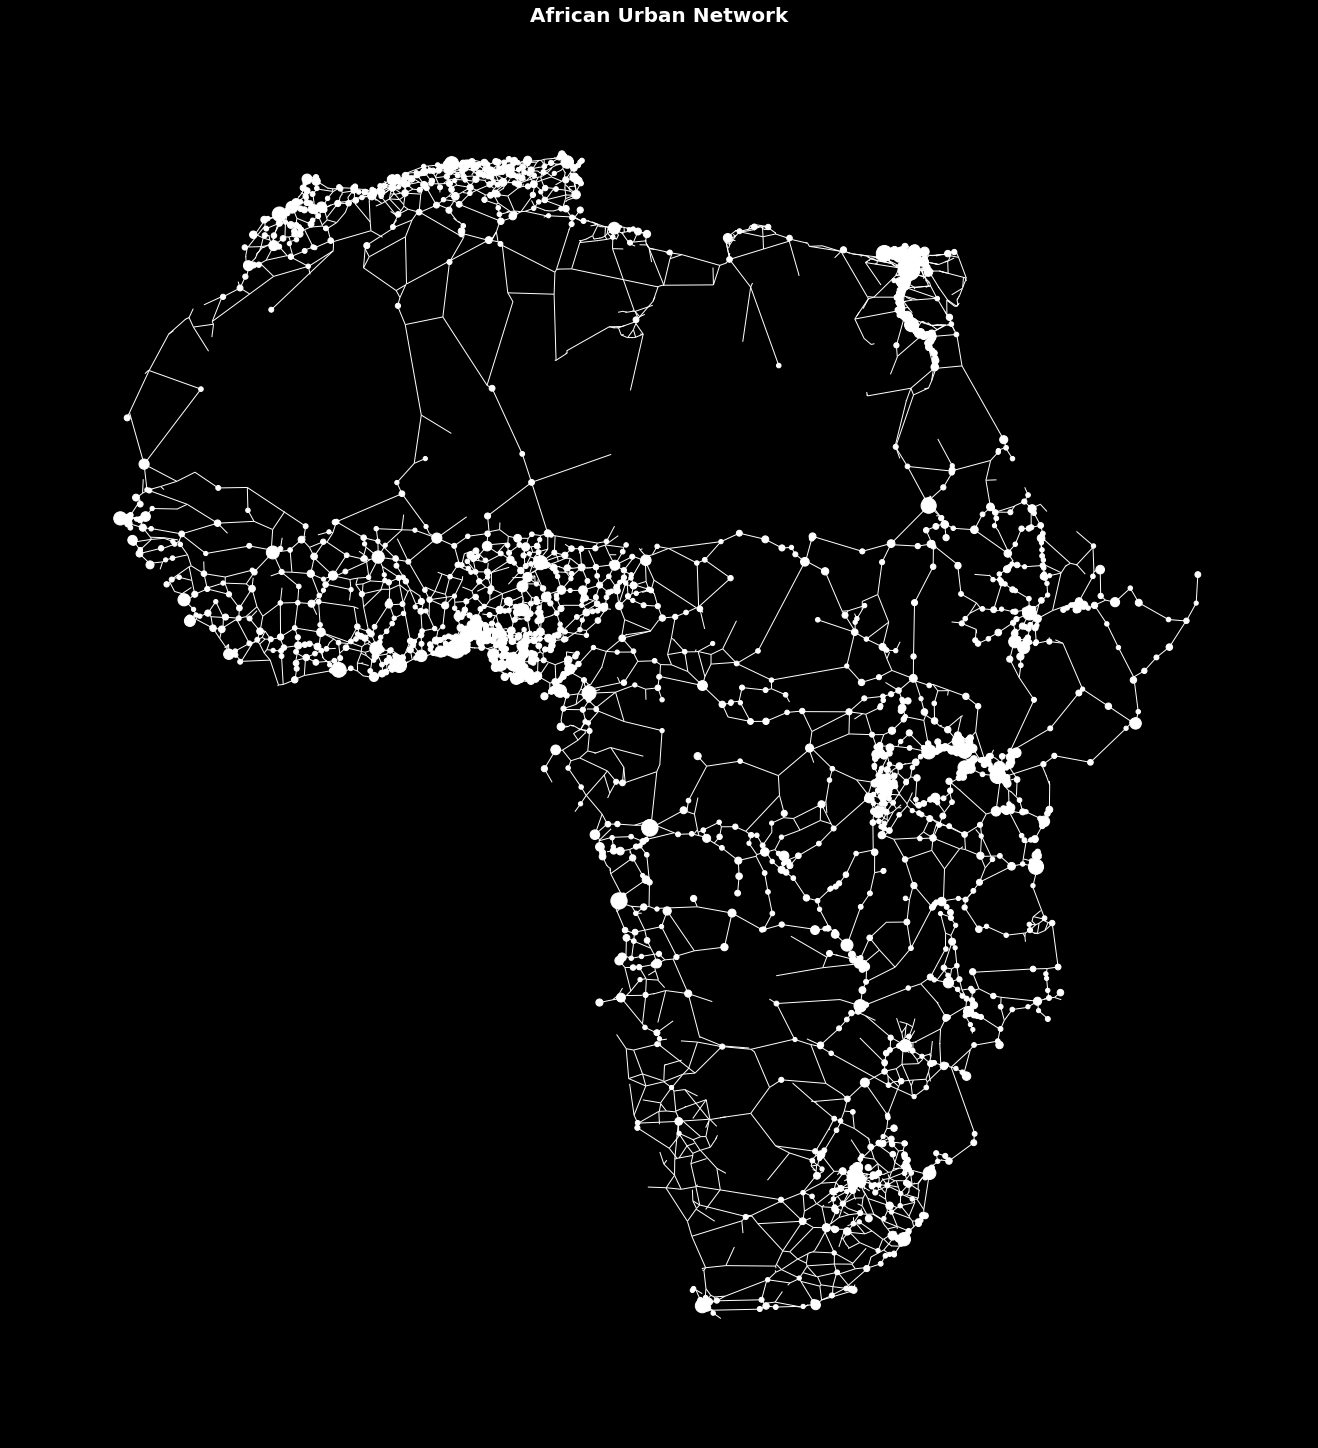

In [6]:
# show the network in space, with population size as node size
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

# get the coordinates
position = {n: [d['x'], d['y']] for n, d in G.nodes(data=True)}
# aside: the sqrt is the best way to represent population, because area is proportional to the square of the radius
size = [np.sqrt(d['Pop2015'] / 100) for n, d in G.nodes(data=True)]

nx.draw_networkx_edges(G, ax=ax, pos=position, edge_color='w', alpha=1)
nx.draw_networkx_nodes(G, ax=ax, pos=position, node_color='w', node_size=size, alpha=1)
ax.set_facecolor('k')

fig.suptitle('African Urban Network', color='w', size=20, weight='bold')

In [7]:
# compute the weighted distance between nodes using dijkstra's algorithm
# 3500 kilometers is the distance from Lagos to Dakar, the ends of a corridor according to the literature
%time distances = dict(nx.all_pairs_dijkstra_path_length(G, weight='l', cutoff=3500))

CPU times: user 22.2 s, sys: 250 ms, total: 22.4 s
Wall time: 22.4 s


In [8]:
# get the index values for roads, which are labeled as 'road' in the 'agglosName' attribute with the node data
junctions = [n for n, d in G.nodes(data=True) if d['agglosName']=='road']

In [9]:
# how many nodes to we start out with?
len(G.nodes())

7361

In [10]:
# remove entries in the dictionary that are junctions, del for delete
for k in junctions:
    del distances[k]

In [11]:
# check to see that we are down to just the cities
len(distances)

2162

In [12]:
# for each entry in distances, remove the self-loops
for i in distances:
    del distances[i][i]

In [13]:
# convert distances to data frame then melt all columns into a single column
pathlengths = pd.DataFrame(distances).reset_index().melt(id_vars='index', var_name='to', value_name='distance')
pathlengths = pathlengths.reset_index(drop=True).rename(columns={'index':'from'})
pathlengths = pathlengths[pathlengths['from']!=pathlengths['to']].reset_index(drop=True)
pathlengths.head()

,from,to,distance
0,5425,8211,0.798800
1,1000559,8211,1.113085
2,1000567,8211,1.314500
3,2333,8211,4.294382
4,1027090,8211,4.532485


In [14]:
nodes = nodes.set_index('Agglomeration_ID')
nodes.head()

,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
Agglomeration_ID,,,,,,,,
2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


In [15]:
# compute a gravity model with population and distance
def gravity(distances, nodes, alpha=1, beta=1):
    # compute the denominator
    denominator = 0
    for i in distances:
        for j in distances[i]:
            denominator += (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015'])
    
    # compute the gravity model
    gravity = {}
    for i in distances:
        gravity[i] = {}
        for j in distances[i]:
            gravity[i][j] = (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015']) / denominator
    
    return gravity

# wrap it into a data frame
def flow_dataframe(flows):
    df = pd.DataFrame(flows).reset_index().melt(id_vars='index', var_name='to', value_name='flow')
    df = df.reset_index(drop=True).rename(columns={'index':'from'})
    df = df[df['from']!=df['to']].reset_index(drop=True)
    return df

In [16]:
%time flows = flow_dataframe(gravity(distances, nodes, beta=2.0))

CPU times: user 1min 31s, sys: 207 ms, total: 1min 32s
Wall time: 1min 32s


In [17]:
# these flows sum to 1 and should represent the proportion of total flows in Africa
flows['flow'].sum()

0.9999999999999541

In [18]:
# filter flows out flows that are 0 
flows_trimmed = flows[flows['flow']>0].reset_index(drop=True)

In [19]:
# get shortest paths between all nodes
paths = dict(nx.all_pairs_dijkstra_path(G, weight='l', cutoff=3500))

In [20]:
# convert paths to a dataframe, reset the index and melt the data
paths = pd.DataFrame(paths).reset_index().melt(id_vars='index', var_name='to', value_name='path')
paths = paths.reset_index(drop=True).rename(columns={'index':'from'})

In [21]:
# filter paths that are in the flows dataframe
print(paths.shape)
paths = paths[paths['from'].isin(flows_trimmed['from']) & paths['to'].isin(flows_trimmed['to'])].reset_index(drop=True)
print(paths.shape)

(54184321, 3)
(4674244, 3)


In [22]:
# merge paths and flows
paths = paths.merge(flows_trimmed, on=['from', 'to'], how='left')

In [23]:
# remove self loops
paths = paths[paths['from']!=paths['to']].reset_index(drop=True)
# remove nan values
paths = paths[paths['path'].notnull()].reset_index(drop=True)
paths.head()

,from,to,path,flow
0,2333,8211,"[8211, 2333]",8.823502e-05
1,5425,8211,"[8211, 5425]",1.258136e-05
2,8208,8211,"[8211, 8208]",7.249173e-07
3,3833,8211,"[8211, 2333, 3833]",3.211520e-07
4,1364,8211,"[8211, 2333, 1068481, 1364]",1.252663e-07


In [24]:
# map over paths to get pairs in a moving window
def get_pairs(path):
    pairs = []
    for i in range(len(path)-1):
        pairs.append((path[i], path[i+1]))
    return pairs

# map over paths to get pairs in a moving window
paths['pairs'] = paths['path'].map(get_pairs)

In [25]:
# expand pairs column so that each element of the list becomes a row
paths = paths.explode('pairs').reset_index(drop=True)

# rename from, to columns into origin and destination
paths = paths.rename(columns={'from':'origin', 'to':'destination'})

# split pairs into from and to columns
paths[['from', 'to']] = pd.DataFrame(paths['pairs'].tolist(), index=paths.index)
paths.head()

,origin,destination,path,flow,pairs,from,to
0,2333,8211,"[8211, 2333]",8.823502e-05,"(8211, 2333)",8211,2333
1,5425,8211,"[8211, 5425]",1.258136e-05,"(8211, 5425)",8211,5425
2,8208,8211,"[8211, 8208]",7.249173e-07,"(8211, 8208)",8211,8208
3,3833,8211,"[8211, 2333, 3833]",3.211520e-07,"(8211, 2333)",8211,2333
4,3833,8211,"[8211, 2333, 3833]",3.211520e-07,"(2333, 3833)",2333,3833


In [26]:
paths = paths.drop(columns=['flow'])
# join the paths with the flows dataframe
flows_imputed = paths.merge(flows_trimmed, left_on=['origin', 'destination'], right_on=['from', 'to'], how='left')

# rename from_x and to_x columns into from and to
flows_imputed = flows_imputed.rename(columns={'from_x':'from', 'to_x':'to'})

# select from, to, flow, flow_delayed, flow_reduced columns
flows_imputed = flows_imputed[['from', 'to', 'flow']]

# group by from, to and sum the flows
flows_imputed = flows_imputed.groupby(['from', 'to'], as_index=False).sum()

In [27]:
# colorcet is a great repository of palettes
import colorcet as cc

Text(0.5, 1.0, 'Spatial Interaction in Africa')

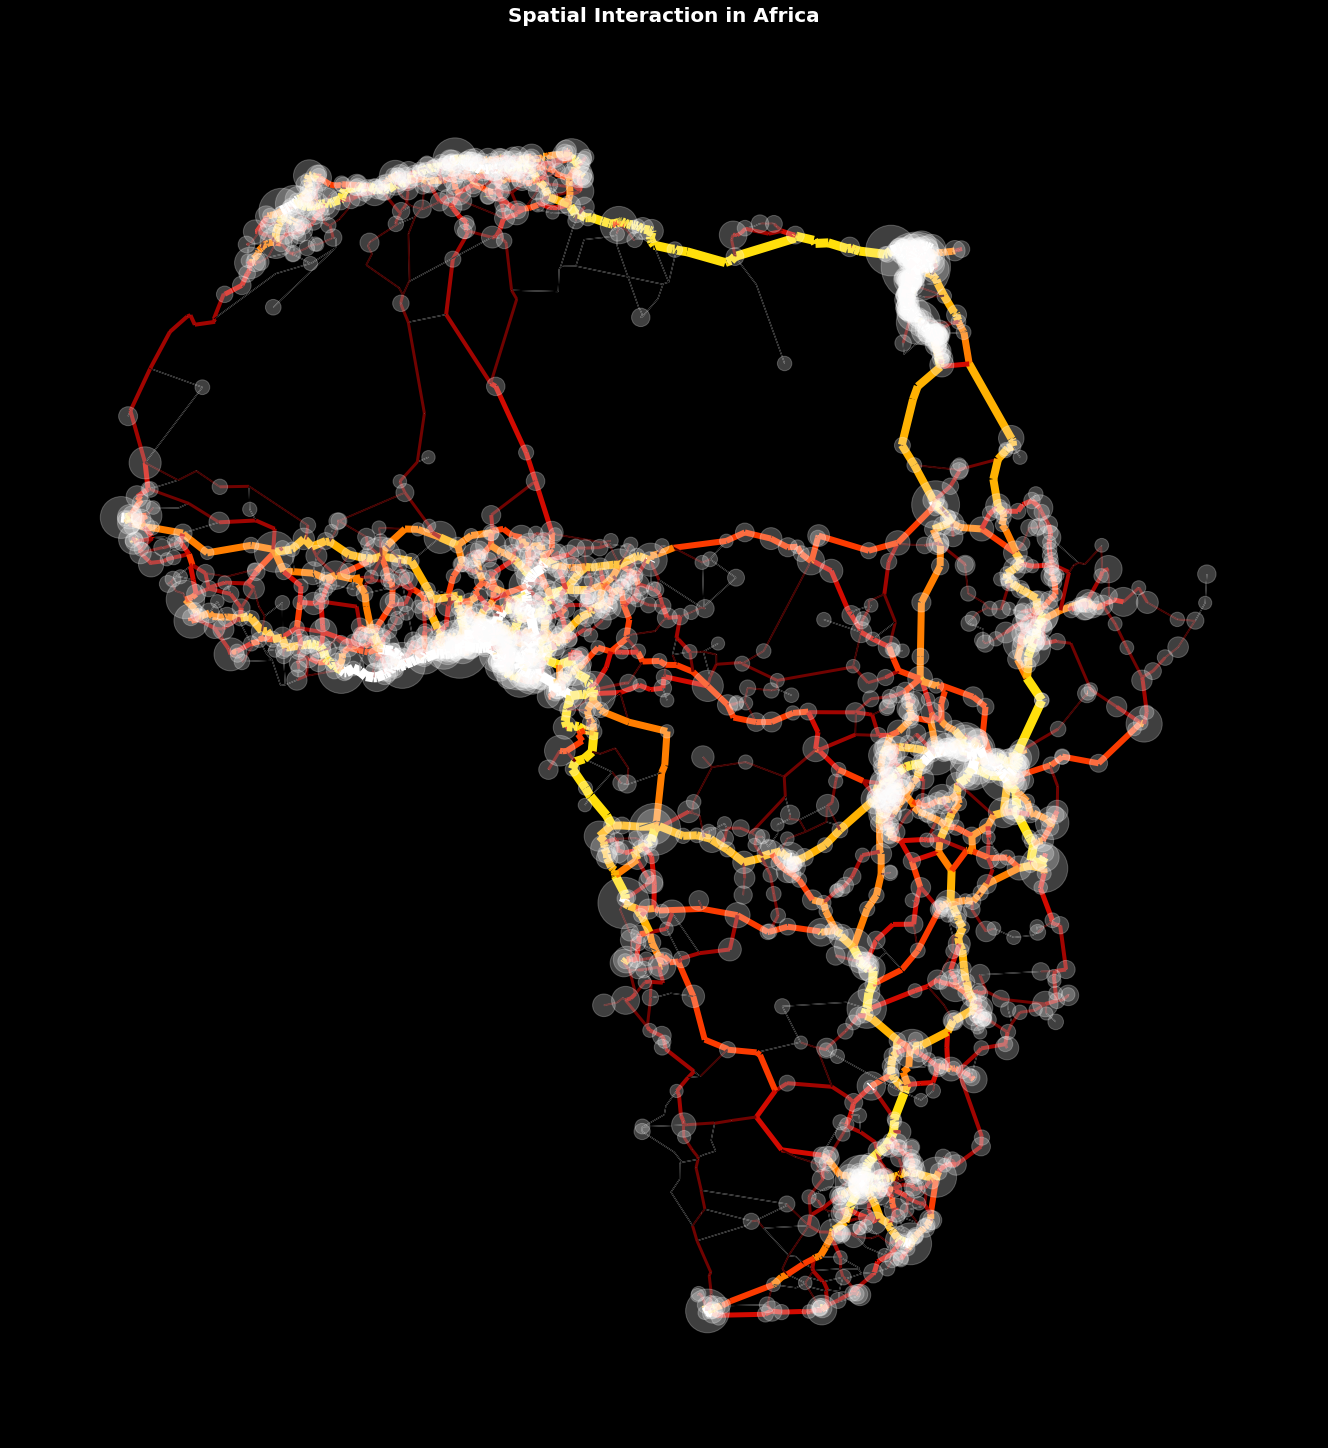

In [28]:
# create a networkx graph from the flows_imputed dataframe
G_imputed = nx.from_pandas_edgelist(flows_imputed, source='from', target='to', edge_attr=['flow'])

# add node attributes
nx.set_node_attributes(G_imputed, nodes.to_dict('index'))

# plot the network
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

# set the node positions
pos = dict(zip(list(G_imputed.nodes()), [[v['x'], v['y']] for k, v in G_imputed.nodes(data=True)]))

# set the node size
node_size = [d['Pop2015'] for k, d in G_imputed.nodes(data=True)]

# draw the nodes
nx.draw_networkx_nodes(G_imputed, pos=pos, node_size=np.sqrt(node_size), node_color='w', alpha=0.25, ax=ax)

# get edge colors
edge_color = [d['flow'] for u, v, d in G_imputed.edges(data=True)]

# break it up into quantiles
edge_color = pd.qcut(edge_color, 10, labels=False)

# draw the edges coloured by the flow
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color='w', width=1, ax=ax)
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color=edge_color, width=edge_color + 1, ax=ax, edge_cmap=cc.cm.fire)

# set axis to black
ax.set_facecolor('k')

# turn axis off
ax.set_axis_off()

# set the title
ax.set_title('Spatial Interaction in Africa', color='w', fontsize=20, fontweight='bold')
